In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoConfig, AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "../data/rocov2"

In [3]:
df = pd.read_csv(os.path.join(DATA_PATH, "processed", "train_top10_kcf.csv"))
df.head()

,ID,Caption,CUIs,CUI_caption,keywords
0,ROCOv2_2023_train_000001,Head CT demonstrating left parotiditis.,C0040405,X-Ray Computed Tomography,"X-ray, Parotid gland, Side view, Left parotitis."
1,ROCOv2_2023_train_000006,5.1 cm x 3.4 cm x 4 cm multiloculated hepatic ...,C0040405,X-Ray Computed Tomography,"X-ray, Liver, Side, Multiloculated abscess."
2,ROCOv2_2023_train_000010,Preop CT showing left orbital floor fracture,C0040405,X-Ray Computed Tomography,"X-ray, Orbit, Floor of Orbit from below, Fract..."
3,ROCOv2_2023_train_000011,Postop 22-month CT scan (sagittal): Posteriorl...,C0040405,X-Ray Computed Tomography,"X-ray, Spine, Sagittal View, Normal."
4,ROCOv2_2023_train_000015,CT demonstrating partially obstructed airway.C...,C0040405,X-Ray Computed Tomography,"Computed Tomography, Airway, Oblique View of, ..."


In [4]:
config = AutoConfig.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
tokenizer = AutoTokenizer.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
radbert = AutoModel.from_pretrained('zzxslp/RadBERT-RoBERTa-4m', config=config)

Some weights of RobertaModel were not initialized from the model checkpoint at zzxslp/RadBERT-RoBERTa-4m and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
bert_res = []
for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating BERT output"):
    # caption = row["Caption"] + " " + row["CUI_caption"]
    caption = row["keywords"]
    inputs = tokenizer(caption, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
    outputs = radbert(**inputs)
    bert_res.append(outputs.last_hidden_state[:, 0, :].detach().numpy())

df["radbert_output"] = bert_res

Generating BERT output:   0%|          | 0/6490 [00:00<?, ?it/s]

In [6]:
df.head()

,ID,Caption,CUIs,CUI_caption,keywords,radbert_output
0,ROCOv2_2023_train_000001,Head CT demonstrating left parotiditis.,C0040405,X-Ray Computed Tomography,"X-ray, Parotid gland, Side view, Left parotitis.","[[-0.031394806, 0.09491457, -0.047894496, -0.0..."
1,ROCOv2_2023_train_000006,5.1 cm x 3.4 cm x 4 cm multiloculated hepatic ...,C0040405,X-Ray Computed Tomography,"X-ray, Liver, Side, Multiloculated abscess.","[[0.008055497, 0.048807114, -0.07001418, -0.03..."
2,ROCOv2_2023_train_000010,Preop CT showing left orbital floor fracture,C0040405,X-Ray Computed Tomography,"X-ray, Orbit, Floor of Orbit from below, Fract...","[[-0.0359543, 0.059753824, -0.080911905, -0.09..."
3,ROCOv2_2023_train_000011,Postop 22-month CT scan (sagittal): Posteriorl...,C0040405,X-Ray Computed Tomography,"X-ray, Spine, Sagittal View, Normal.","[[-0.036668044, 0.112872526, -0.04908259, -0.0..."
4,ROCOv2_2023_train_000015,CT demonstrating partially obstructed airway.C...,C0040405,X-Ray Computed Tomography,"Computed Tomography, Airway, Oblique View of, ...","[[-0.022708643, 0.11709809, -0.049740884, -0.1..."


In [7]:
tsne = TSNE(n_components=2)
X = df["radbert_output"].apply(lambda x: x[0])
X = np.array(X.to_list())
X_embedded = tsne.fit_transform(X)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
X_embedded

array([[ -0.8306139,  12.568135 ],
       [  4.8020635, -14.644208 ],
       [ -2.0779965,  31.194471 ],
       ...,
       [  3.6271312,  36.310036 ],
       [ -5.1561503,  42.541904 ],
       [-75.44732  ,  26.44449  ]], dtype=float32)

In [22]:
min_x = min(X_embedded[:,0])
max_x = max(X_embedded[:,0])

min_y = min(X_embedded[:,1])
max_y = max(X_embedded[:,1])

print(min_x, max_x)
print(min_y, max_y)

-90.71151 74.289894
-100.298416 83.06943


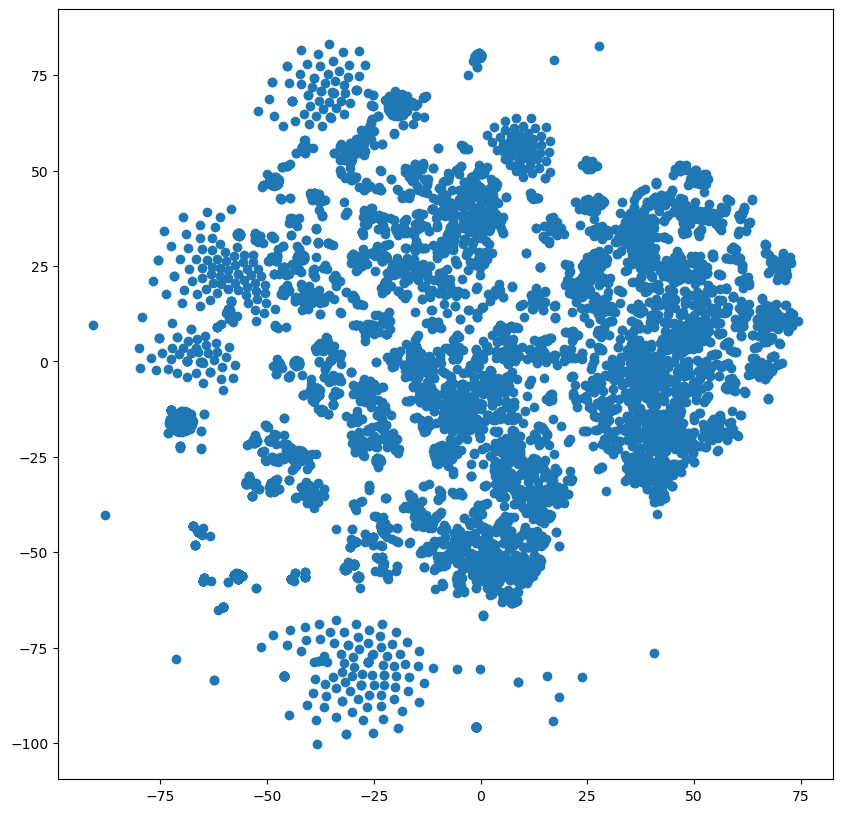

In [11]:
#plot the tsne with clusters having different colors. enclose the clusters in an oval and write the cluster number
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])#, c=df["cluster"], cmap="viridis")
# for i in range(5):
    # cluster = X_embedded[df["cluster"] == i]
    # x, y = cluster[:, 0], cluster[:, 1]
    # x_mean, y_mean = np.mean(x), np.mean(y)
    # plt.text(x_mean, y_mean, str(i), fontsize=12)
    # plt.gca().add_artist(plt.Circle((x_mean, y_mean), 0.5, fill=False, color="red"))
plt.savefig("../fig/temp.png")